In [1]:
#!/usr/bin/env python
# # -*- coding: utf-8 -*-
#!/usr/bin/env python
#!pip install tensorflow==1.15

import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob, os, inspect
import argparse
import time
import seaborn as sns
# import matplotlib
# matplotlib.use("Qt5Agg")
# #matplotlib.use('Agg')
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt
import pandas as pd
import sys,inspect
sys.path.append("C:\\Users\\Vinamr J\\Documents\\qic\\qrc\\hqr\\hqr-master\\chaos\\Postprocess")
sys.path.append("C:\\Users\\Vinamr J\\Documents\\qic\\qrc\\hqr\\hqr-master\\chaos\\Methods\\Models\\Utils")

import utils  # for utils.py
from utils import *
import global_utils  # for global_utils.py

# import utils
# from utils import *
# import sys
# sys.path.append('../Methods/Models/Utils')
# import global_utils

In [2]:
sysname, tidx = "SST_perturb", 2
file_path = os.path.abspath("HQRC_perturb_analysis.ipynb")
current_directory = os.path.dirname(file_path)
mid_directory = os.path.dirname(current_directory)
parent_directory = os.path.dirname(mid_directory)

print("Current Directory:", current_directory)
print("Parent Directory:", parent_directory)

#current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
results_dir = os.path.join(os.path.dirname(mid_directory), "Results")  # Use os.path.join for path concatenation
print(results_dir)

eval_path = os.path.join(results_dir, sysname, 'Evaluation_Data')
print(eval_path)

model_path = os.path.join(results_dir, sysname, 'Trained_Models')
print(model_path)

fig_path = os.path.join(results_dir, sysname, 'Eval_Figures')
if not os.path.isdir(fig_path):
    os.makedirs(fig_path)  # Use os.makedirs to create parent directories if needed
print(fig_path)

Current Directory: c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Data\SST
Parent Directory: c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST_perturb\Evaluation_Data
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST_perturb\Trained_Models
c:\Users\Vinamr J\Documents\qic\qrc\hqr\hqr-master\chaos\Results\SST_perturb\Eval_Figures


In [3]:
models = []
samples = []
V_values = [10]
alpha_values = [0.5]
beta_values = [1e-7]
for V in V_values:
    for alpha in alpha_values:
        for beta in beta_values:
            string1 = f"hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_5-A_{alpha}-J_2.0-fJ_1-V_{V}-NL_0-IPL_300-IUL_0-REG_{beta}-AU_0-NICS_5"
            string2 = f"HQRC-V={V}-alpha={alpha}-beta={beta}"
            models.append([os.path.join(eval_path,string1),string2])
            samples.append(string2)
title = "Sea Surface Temperatures"

In [4]:
rmse_dict = dict()
targets = []
outputs = []
targets_train = []
outputs_train = []
sp_outputs = dict()
sp_targets = dict()
Wouts = dict()
coeffs = dict()
rmnse_avg_train_dict = dict()
rmnse_avg_test_dict = dict()
for i in range(len(models)):
    rfolder, label = models[i][0], models[i][1]
    fname = os.path.join(rfolder, 'results.pickle')
    if os.path.isfile(fname):
        with open(fname, 'rb') as rfile:
            try:
                rs = pickle.load(rfile)
            except:
                continue
            #print(rs.keys())
            qs = QResults()
            qs.rmnse_avg_test = rs['rmnse_avg_TEST']
            qs.rmnse_avg_train = rs['rmnse_avg_TRAIN']
            qs.n_pred_005_avg_test = rs['num_accurate_pred_005_avg_TEST']
            qs.n_pred_005_avg_train = rs['num_accurate_pred_005_avg_TRAIN']
            qs.n_pred_050_avg_test = rs['num_accurate_pred_050_avg_TEST']
            qs.n_pred_050_avg_train = rs['num_accurate_pred_050_avg_TRAIN']
            qs.model_name = rs['model_name']
            #if qs.rmnse_avg_test != np.inf and qs.rmnse_avg_train != np.inf:
                #print(rs.keys())
            #print(qs.model_name)
            #print('train={}, test={}'.format(qs.rmnse_avg_train, qs.rmnse_avg_test))
            #qs.info()
            rmnse_avg_train_dict[label] = rs['rmnse_avg_TRAIN']
            rmnse_avg_test_dict[label] = rs['rmnse_avg_TEST']
            pred_test = rs['predictions_all_TEST']
            truth_test = rs['truths_all_TEST']
            pred_train = rs['predictions_all_TRAIN']
            truth_train =rs['truths_all_TRAIN']
            print(pred_test.shape)
            M = len(pred_test)
            print('{} Number of test'.format(qs.model_name), M)
            rmsels = []
            for j in range(M):
                    rmsels.append(calNRMSE(pred_test[j], truth_test[j]))

            rmse_dict[label] = np.mean(np.array(rmsels), axis=0)
            print(rmse_dict[label].shape)


            targets = truth_test #Contains all perturbations 
            outputs = pred_test

            targets_train = truth_train #Contains all perturbations for the 0th index of test week (116th)
            outputs_train = pred_train
            # For frequency
            sp_outputs[label] = rs['sp_pred_TEST']
            sp_targets[label] = rs['sp_true_TEST']
    else:
        print('Not found {}'.format(fname))
    # if trained_models is not None:
    #     rfolder, label = trained_models[i][0], trained_models[i][1]
    #     fname = os.path.join(rfolder, 'data.pickle')
    #     if os.path.isfile(fname):
    #         print('File existed: ', fname)
    #         with open(fname, 'rb') as rfile:
    #             #try:
    #             rs = pickle.load(rfile)
    #             #except:
    #             #    continue
    #             print(rs.keys())
    #             coeffs[label] = np.array(rs['coeffs'])
    #             Wouts[label]  = rs['W_out'][:-1].reshape((coeffs[label].shape[0], -1))
    #             print(Wouts[label].shape, coeffs[label].shape)
    #     else:
    #         print('Not found saved model {}'.format(fname))

(6, 300, 5)
hqrc_pinv-RDIM_5-N_used_427-DL_40-Nqr_5-A_0.5-J_2.0-fJ_1-V_10-NL_0-IPL_300-IUL_0-REG_1e-07-AU_0-NICS_5 Number of test 6
(300,)


In [14]:
# #Manually calculated ignore
# model_test_error = []
# test_avg_error = []
# for label in samples:
#     model_test_error.append([label,np.mean(rmse_dict[label])])
#     test_avg_error.append(np.mean(rmse_dict[label]))
# print(model_test_error)
# print("Test Average error = ",np.mean(test_avg_error))

In [5]:
print(rmnse_avg_train_dict)
print(rmnse_avg_test_dict)
error_array_test = []
error_array_train = []
for label in samples:
    error_array_train.append(rmnse_avg_train_dict[label])
    error_array_test.append(rmnse_avg_test_dict[label])
print("Train average error for HQRC =", np.mean(error_array_train))
print("Test average error for HQRC =", np.mean(error_array_test))

{'HQRC-V=10-alpha=0.5-beta=1e-07': 0.2666714377930213}
{'HQRC-V=10-alpha=0.5-beta=1e-07': 0.8413083267456254}
Train average error for HQRC = 0.2666714377930213
Test average error for HQRC = 0.8413083267456254


In [6]:
predictions = outputs[1:]
truths = targets[1:]
mean_predictions = np.mean(predictions, axis=0)
std_predictions = np.std(predictions, axis=0)
print("Mean predictions shape:", mean_predictions.shape)
print("Standard deviation shape:", std_predictions.shape)
print("Mean predictions:\n", mean_predictions)
print("Standard deviation:\n", std_predictions)
mean_truths = np.mean(truths, axis=0)
std_truths = np.std(truths, axis=0)
# print("Mean predictions shape:", mean_truths.shape)
# print("Standard deviation shape:", std_truths.shape)
# print("Mean predictions:\n", mean_truths)
# print("Standard deviation:\n", std_truths)

Mean predictions shape: (300, 5)
Standard deviation shape: (300, 5)
Mean predictions:
 [[468.01322985 -10.10798389  34.37794573 -57.6478374   56.04305485]
 [418.10666674 -21.71183322  13.67178465 -44.92205525  56.96471031]
 [386.63106613  -9.36383328   2.73623953 -66.54032604  58.15581033]
 ...
 [-26.91658988  99.79982111 -73.76957461 -38.37327312  26.09514344]
 [ 29.11096456  98.33973626 -67.90964691 -43.56069644  27.92157337]
 [ 87.24522901  96.20831324 -56.39900412 -47.19766106  29.3533856 ]]
Standard deviation:
 [[49.91671852 13.68608578 11.73791894 10.72346444  4.77958371]
 [40.16774537  7.58138152 15.82122801 12.27459894  5.30395541]
 [33.06776729  9.89897969 16.13352812  2.92282109  4.0724817 ]
 ...
 [69.32166808 19.50229237 12.06969916 40.91984301 28.07875202]
 [78.84196801 20.06863728 14.92620623 37.29582947 25.29384011]
 [87.89497676 21.69373482 20.56080096 32.98817576 22.63171031]]


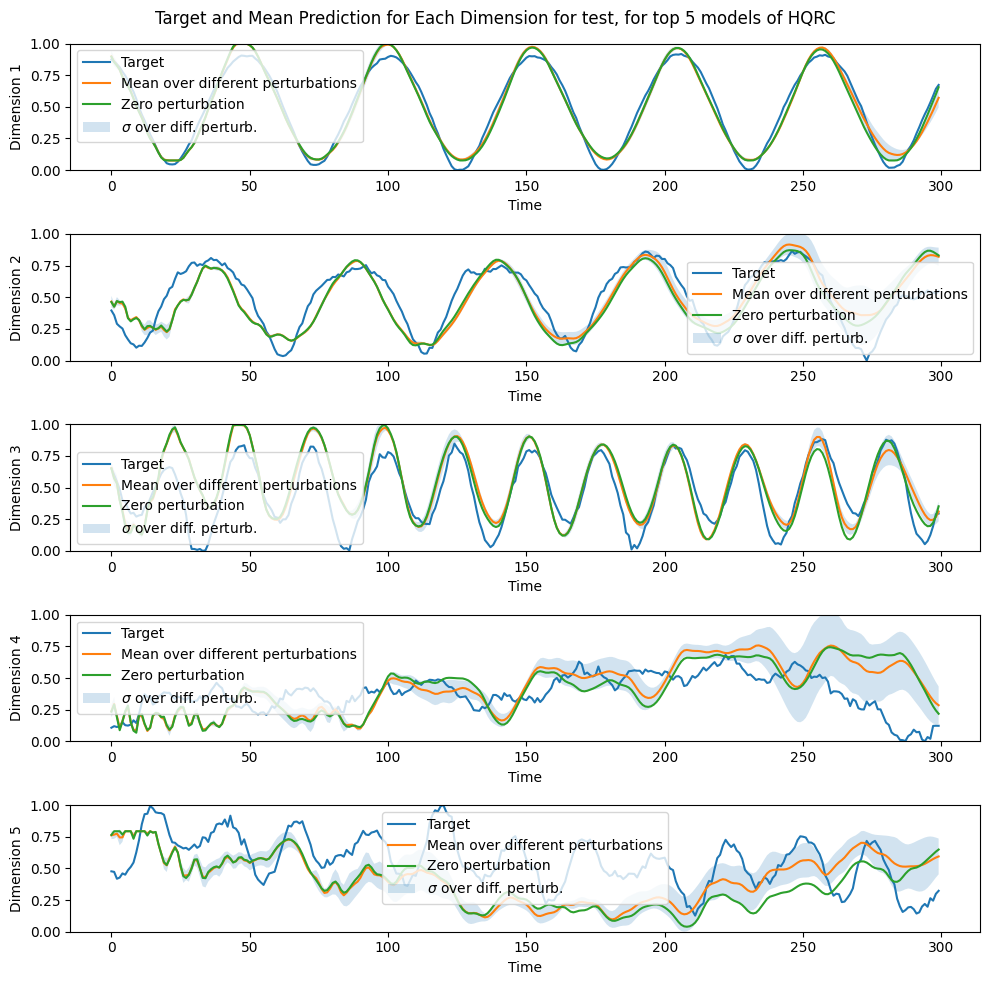

In [9]:
num_dimensions = mean_truths.shape[1]
# Create subplots
fig, axs = plt.subplots(num_dimensions, 1, figsize=(10, 10))

# Iterate over each dimension
for dim in range(num_dimensions):
    # Extract arrays for the current dimension
    target_dim = mean_truths[:, dim]
    out_dim = mean_predictions[:, dim]
    std_dim = std_predictions[:, dim]
    zero_pert = predictions[0][:,dim]
    # Calculate min and max values across all arrays for current dimension
    data_min = min(np.min(target_dim), np.min(out_dim - std_dim),np.min(zero_pert))
    data_max = max(np.max(target_dim), np.max(out_dim + std_dim),np.max(zero_pert))

    # Normalize arrays to [0, 1] range
    target_dim = (target_dim - data_min) / (data_max - data_min)
    out_dim = (out_dim - data_min) / (data_max - data_min)
    std_dim = std_dim / (data_max - data_min)  # std deviation is normalized accordingly
    zero_pert = (zero_pert - data_min) / (data_max - data_min)
    # Plot target and output arrays
    axs[dim].plot(target_dim, label='Target')
    axs[dim].plot(out_dim, label='Mean over different perturbations')
    axs[dim].plot(zero_pert,label='Zero perturbation')
    axs[dim].fill_between(range(len(out_dim)), out_dim - std_dim, out_dim + std_dim, alpha=0.2, label=r'$\sigma$ over diff. perturb.')

    # Set y-axis limits to [0, 1]
    axs[dim].set_ylim(0, 1)

    # Add labels and legend
    axs[dim].set_xlabel('Time')
    axs[dim].set_ylabel(f'Dimension {dim + 1}')
    axs[dim].legend()

# Add title
plt.suptitle('Target and Mean Prediction for Each Dimension for test, for top 5 models of HQRC')
# Adjust layout
plt.tight_layout()

# Plot frequency
plt.show()